In [11]:
%reload_ext autoreload
%autoreload 2

import projcore as pc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
from scipy.spatial.distance import pdist, squareform
import ast
import random
import seaborn as sns
from gensim.models import Word2Vec
import networkx as nx

pd.set_option('display.max_columns', None)

In [25]:
pc.download_kaggle_datasets()
org_battles_df = pd.read_csv('BattlesStaging_01012021_WL_tagged.csv')
card_list_df = pd.read_csv('CardMasterListSeason18_12082020.csv')
winning_card_list_df = pd.read_csv('Wincons.csv')


File BattlesStaging_01012021_WL_tagged/BattlesStaging_01012021_WL_tagged.csv already exists, skipping download
File CardMasterListSeason18_12082020.csv already exists, skipping download
File Wincons.csv already exists, skipping download
clash-royal-data.csv already exists, skipping download


In [26]:
battles_df = pc.feature_preprocessing(org_battles_df, winning_card_list_df)

KeyboardInterrupt: 

In [11]:
battles_df.head(100).to_csv("battles_subset.csv", index=False)


In [ ]:
unique_decks = battles_df["winner.card_set"].unique()
deck_wins = battles_df.groupby("winner.card_set").size()
deck_losses = battles_df.groupby("loser.card_set").size()
deck_total_games = deck_wins.add(deck_losses, fill_value=0)
deck_win_rate = (deck_wins / deck_total_games).fillna(0)  # Win rate as fraction
win_rate_dict = deck_win_rate.to_dict()

# DIFFERENT TASK?
winner_deck_counts = battles_df["winner.card_set"].value_counts()
loser_deck_counts = battles_df["loser.card_set"].value_counts()
deck_counts = winner_deck_counts.add(loser_deck_counts, fill_value=0)

In [10]:
valid_decks = set(deck_counts[deck_counts >= 25].index)
filtered_battles_df = battles_df[battles_df["winner.card_set"].isin(valid_decks)]
unique_decks = filtered_battles_df["winner.card_set"].unique()
print("Number of unique decks:", len(unique_decks))

Number of unique decks: 7957


In [ ]:

# Compute win rates for each deck
deck_wins = battles_df.groupby("winner.card_set").size()
deck_losses = battles_df.groupby("loser.card_set").size()
deck_total_games = deck_wins.add(deck_losses, fill_value=0)
deck_win_rate = (deck_wins / deck_total_games).fillna(0)  # Win rate as fraction


# Store win rates in a dictionary
win_rate_dict = deck_win_rate.to_dict()

# Construct a Deck Similarity Graph (Graph-based Representation)
G = nx.Graph()

# Add decks as nodes with win rate as an attribute
for deck in unique_decks:
    G.add_node(deck, win_rate=win_rate_dict.get(deck, 0))

# Define a function to compute deck similarity (overlap of at least 5 cards)
def deck_similarity(deck1, deck2, min_overlap=5):
    return len(set(deck1) & set(deck2)) >= min_overlap
print("Number of nodes:", G.number_of_nodes())

# Add edges between similar decks (reducing full pairwise computation)
for i in range(len(unique_decks)):
    for j in range(i + 1, len(unique_decks)):
        if deck_similarity(unique_decks[i], unique_decks[j]):
            G.add_edge(unique_decks[i], unique_decks[j])
print("Number of edges:", G.number_of_edges())
# Train DeepWalk using Word2Vec on random walks from the graph
walks = [list(map(str, nx.single_source_shortest_path_length(G, node, cutoff=10).keys())) for node in G.nodes()]
deepwalk_model = Word2Vec(sentences=walks, vector_size=64, window=5, min_count=1, sg=1, workers=4)

# Extract embeddings for each deck
deck_embeddings = {deck: deepwalk_model.wv[str(deck)] for deck in G.nodes()}
print("Number of embeddings:", len(deck_embeddings))
# Convert embeddings to a DataFrame for visualization
deck_embedding_df = pd.DataFrame(deck_embeddings).T
deck_embedding_df["WinRate"] = [G.nodes[deck]["win_rate"] for deck in deck_embedding_df.index]





Number of nodes: 7957
Number of edges: 338824
Number of embeddings: 7957


ValueError: Could not interpret value `X` for `x`. Value is a string, but `data` was not passed.

<Figure size 1000x600 with 0 Axes>

In [19]:
from sklearn.manifold import TSNE

deck_embedding_df.columns = deck_embedding_df.columns.astype(str)

# Try different hyperparameters
tsne = TSNE(
    n_components=2,        # Project down to 2D
    perplexity=40,         # Try values from 5 to 50
    learning_rate=200,     # Try values from 10 to 1000
    n_iter=3000,           # Increase iterations for better convergence
    metric="cosine",       # Cosine distance works well with embeddings
    init="random",         # Prevents local minimum issues
    random_state=42
)

# Apply t-SNE
deck_embedding_df[["X", "Y"]] = tsne.fit_transform(deck_embedding_df.drop(columns=["WinRate"]))


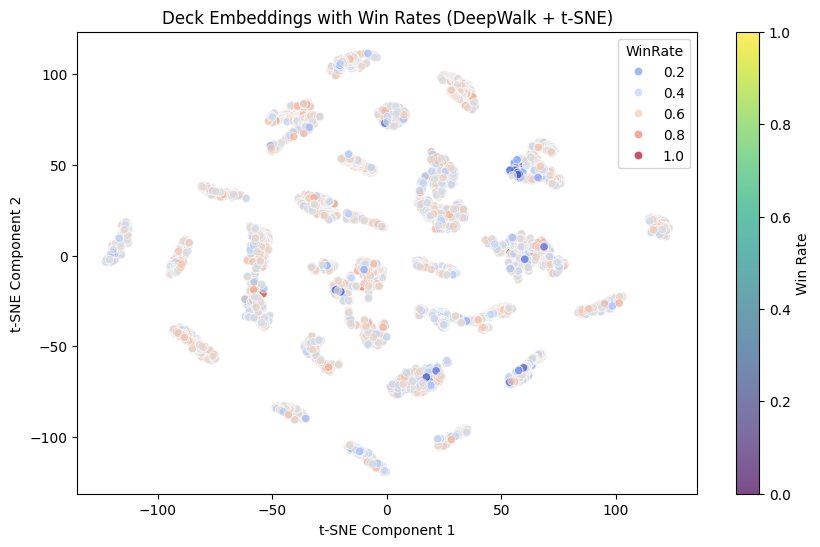

In [21]:
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(x="X", y="Y", hue="WinRate", palette="coolwarm", alpha=0.7, data=deck_embedding_df)
plt.title("Deck Embeddings with Win Rates (DeepWalk + t-SNE)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(scatter.collections[0], label="Win Rate")  # Ensure colorbar is correctly assigned
plt.show()


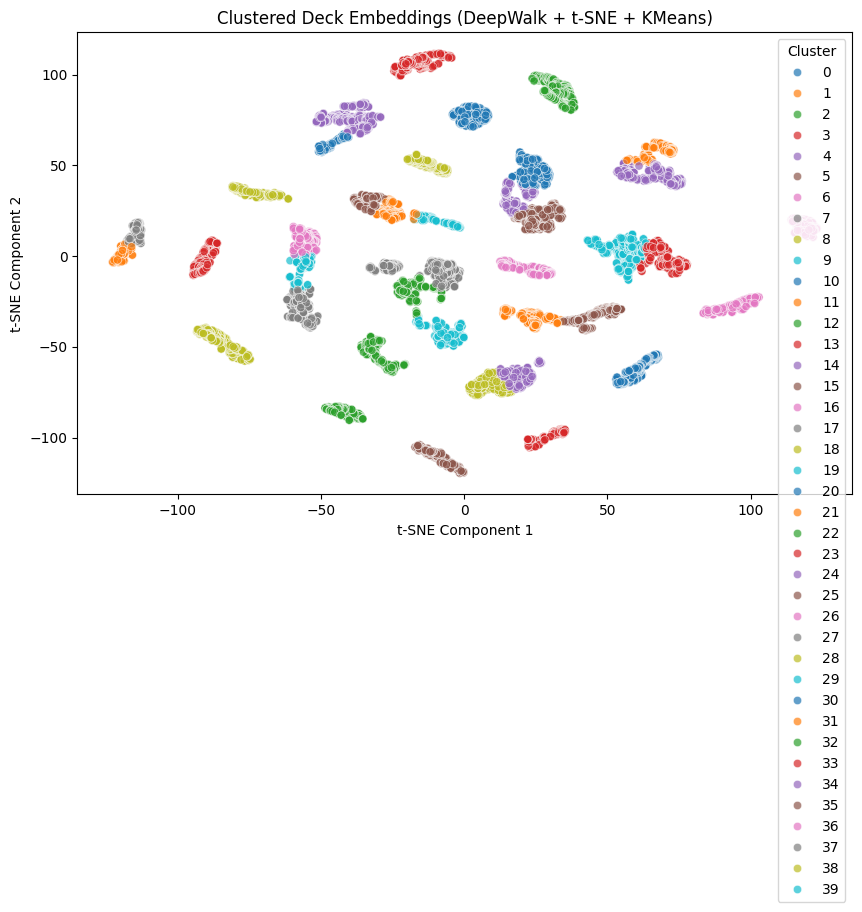


📌 Cluster Summary (Sorted by Win Rate):
             mean  count
Cluster                 
2        0.539903    272
28       0.537349    172
18       0.532946    166
15       0.529027    125
8        0.528248    260
39       0.527797    118
19       0.526737    134
24       0.526358    305
6        0.525413    203
23       0.523917    150
22       0.523529    159
4        0.523283    175
36       0.521391    184
27       0.520990    235
16       0.520548    162
13       0.520234    239
38       0.518572    222
31       0.517168    146
26       0.516559    195
35       0.516446    252
12       0.516136    232
29       0.516006    237
7        0.513682    105
0        0.511280    104
33       0.510743    252
3        0.509062    215
32       0.508891    189
25       0.507847    211
37       0.506048    120
30       0.504695    256
17       0.503191    243
20       0.499579    227
21       0.498439    110
9        0.498367    316
14       0.497092    195
11       0.496451    169
5        

In [22]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Assume 'deck_embedding_df' already contains t-SNE embeddings and win rates

# Choose number of clusters (adjust as needed)
num_clusters = 40

# Apply KMeans clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
deck_embedding_df["Cluster"] = kmeans.fit_predict(deck_embedding_df[["X", "Y"]])

# Plot clustered deck embeddings
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    x="X", y="Y", hue="Cluster", palette="tab10", data=deck_embedding_df, alpha=0.7
)
plt.title("Clustered Deck Embeddings (DeepWalk + t-SNE + KMeans)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Cluster", loc="best")
plt.show()

# Compute cluster statistics (mean win rate & number of decks per cluster)
cluster_summary = deck_embedding_df.groupby("Cluster")["WinRate"].agg(["mean", "count"]).sort_values(by="mean", ascending=False)

# Display results
print("\n📌 Cluster Summary (Sorted by Win Rate):")
print(cluster_summary)
